In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
import time
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 绘图函数
import matplotlib.pyplot as plt
def draw_loss(train_loss, test_acc):
    x = range(len(train_loss))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(10, 5))
    # 在第一个子图中绘制训练损失
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    # 在第二个子图中绘制测试精度
    plt.subplot(1, 2, 2)
    plt.plot(x, test_acc, color='r', label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
from torch.utils.data.dataset import random_split
batch_size = 128
# minist数据集
mnist_train = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
# 划分训练集和验证集
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])
# 创建DataLoader
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
val_iter = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=0)
mnist_test = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=False, transform=transforms.ToTensor())
# 通过DataLoader 读取小批量数据样本
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

In [4]:
# torch.nn.Dropout层实现dropout
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
# 准确率计算函数
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net,torch.nn.Module):
            net.eval() 
            #评估模式，不使用dropout
            acc_sum += (net (X).argmax (dim=1) == y).float ().sum().item()
            net.train()
            # 改回训练模式
        n += y.shape[0]
    return acc_sum / n

In [6]:
def train(net, train_iter, val_iter, loss_func, epochs, optimizer):
    train_loss_list = []
    val_acc_list = []
    best_val_acc = 0.0
    stop_rounds = 0
    time_start = time.time()
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        for X,y in train_iter:
            y_hat = net.forward(X)
            l = loss_func(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        val_acc = evaluate_accuracy(val_iter, net)
        train_loss_list.append(train_l_sum / c)
        val_acc_list.append(val_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, val acc %.3f' % (epoch + 1,train_l_sum / c, train_acc_sum / n, val_acc))
        # 早停机制
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            stop_rounds = 0
        else:
            stop_rounds += 1
        if stop_rounds >= 5:
            print("Early stopping!")
            break
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, val_acc_list)

In [7]:
# 神经网络模型
def Net(drop_prob): # 根据dropout的值来初始化
    drop_prob = 0.2
    net_pytorch = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(num_hiddens2, 10)
    )
    for param in net_pytorch.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net_pytorch

In [8]:
epochs = 50
lr = 0.5
loss = nn.CrossEntropyLoss()

In [9]:
num_inputs = 784
num_hiddens1 = 256
num_hiddens2 = 256

epoch 1, train loss 0.6297, train acc 0.790, val acc 0.950
epoch 2, train loss 0.1582, train acc 0.952, val acc 0.974
epoch 3, train loss 0.1146, train acc 0.964, val acc 0.980
epoch 4, train loss 0.0887, train acc 0.973, val acc 0.982
epoch 5, train loss 0.0754, train acc 0.977, val acc 0.989
epoch 6, train loss 0.0668, train acc 0.979, val acc 0.984
epoch 7, train loss 0.0586, train acc 0.982, val acc 0.992
epoch 8, train loss 0.0503, train acc 0.984, val acc 0.992
epoch 9, train loss 0.0457, train acc 0.985, val acc 0.994
epoch 10, train loss 0.0406, train acc 0.987, val acc 0.993
epoch 11, train loss 0.0370, train acc 0.988, val acc 0.994
epoch 12, train loss 0.0339, train acc 0.989, val acc 0.996
epoch 13, train loss 0.0309, train acc 0.990, val acc 0.996
epoch 14, train loss 0.0301, train acc 0.990, val acc 0.997
epoch 15, train loss 0.0285, train acc 0.990, val acc 0.996
epoch 16, train loss 0.0260, train acc 0.992, val acc 0.997
epoch 17, train loss 0.0234, train acc 0.992, val

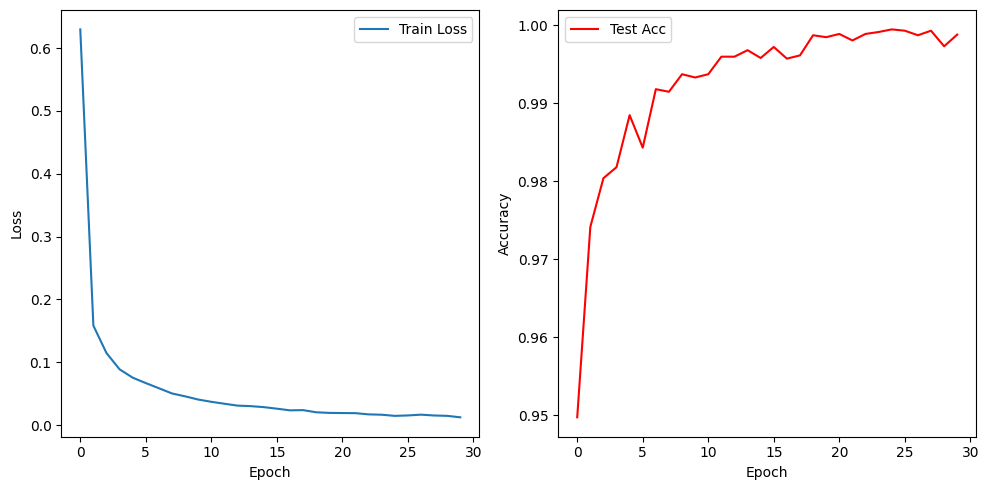

In [10]:
net = Net(0.2) # dropout为0.2
optimizer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, val_iter, loss, epochs, optimizer)

In [11]:
test_acc = evaluate_accuracy(test_iter, net)
print('test acc %.3f' % (test_acc))

test acc 0.983
